### Load the Dataset

In [9]:
import pandas as pd

# Load the dataset
file_path = '../../dataset/data.tsv'
data = pd.read_csv(file_path, sep='\t', header=None, names=['Token', 'POS', 'NER'], skip_blank_lines=False)

# Display the first few rows
print(data.head(20))

                                                Token    POS    NER
0   শনিবার (২৭ আগস্ট) রাতে পটুয়াখালী সদর থানার ভা...    NaN    NaN
1                                              শনিবার    NNP  B-D&T
2                                                 (২৭  PUNCT  B-OTH
3                                              আগস্ট)    NNP  B-D&T
4                                                রাতে    NNC  B-D&T
5                                          পটুয়াখালী    NNP  B-GPE
6                                                 সদর    NNC  I-GPE
7                                               থানার    NNC  I-GPE
8                                          ভারপ্রাপ্ত    ADJ  B-PER
9                                           কর্মকর্তা    NNC  I-PER
10                                              (ওসি)  PUNCT  B-OTH
11                                               মো.    NNP  B-PER
12                                       মনিরুজ্জামান    NNP  I-PER
13                                              

In [10]:
data.shape

(53438, 3)

### Clean and Preprocess the Data

In [11]:
data['Token'].head(3)

0    শনিবার (২৭ আগস্ট) রাতে পটুয়াখালী সদর থানার ভা...
1                                               শনিবার
2                                                  (২৭
Name: Token, dtype: object

In [12]:
# Tokenize and clean tokens (words + noise)
from bnlp import BasicTokenizer
basic_tokenizer = BasicTokenizer()
data['Token'] = data['Token'].apply(lambda x: basic_tokenizer.tokenize(x) if isinstance(x, str) else x)

In [13]:
data['Token'].head(3)

0    [শনিবার, (, ২৭, আগস্ট, ), রাতে, পটুয়াখালী, সদ...
1                                             [শনিবার]
2                                              [(, ২৭]
Name: Token, dtype: object

In [15]:
def process_tokens(tokens):
    if isinstance(tokens, list):
        if len(tokens) == 2:
            return tokens[0]
        else:
            return ' '.join(tokens)  # Detokenize
    return tokens

In [14]:
data['Token'] = data['Token'].apply(process_tokens)
data['Token'].head(3)

0    শনিবার ( ২৭ আগস্ট ) রাতে পটুয়াখালী সদর থানার ...
1                                               শনিবার
2                                                    (
Name: Token, dtype: object

In [16]:
data.isna().sum()

Token    4054
POS      8112
NER      8114
dtype: int64

In [17]:
# Count the number of unique sentences
# A sentence is identified by rows where Token, POS and NER are NaN
blank_rows = data[data['Token'].isna() & data['POS'].isna() & data['NER'].isna()].shape[0]

print(f"Number of sentences in the raw dataset: {blank_rows}")

Number of sentences in the raw dataset: 4054


In [18]:
data_cleaned = data.dropna(how='all')
data_cleaned.reset_index(drop=True, inplace=True)

missing_values = data_cleaned.isna().sum()
missing_values

Token       0
POS      4058
NER      4060
dtype: int64

In [19]:
num_sentences = data_cleaned[data_cleaned['POS'].isna() & data_cleaned['NER'].isna()].shape[0]
num_sentences

4058

In [20]:
# Initialize the 'Sentence #' column
data_cleaned['Sentence #'] = None

# Counter for sentence numbers
sentence_counter = 0

# Iterate over the rows
for index, row in data_cleaned.iterrows():
    if pd.isna(row['POS']) and pd.isna(row['NER']):
        sentence_counter += 1  # Increment counter at the start of a new sentence
    else:
        data_cleaned.at[index, 'Sentence #'] = sentence_counter

# Reorder columns to have 'Sentence #' first
data_cleaned = data_cleaned[['Sentence #', 'Token', 'POS', 'NER']]

In [21]:
data_cleaned.head(20)

,Sentence #,Token,POS,NER
0,None,শনিবার ( ২৭ আগস্ট ) রাতে পটুয়াখালী সদর থানার ...,NaN,NaN
1,1,শনিবার,NNP,B-D&T
2,1,(,PUNCT,B-OTH
3,1,আগস্ট,NNP,B-D&T
4,1,রাতে,NNC,B-D&T
5,1,পটুয়াখালী,NNP,B-GPE
6,1,সদর,NNC,I-GPE
7,1,থানার,NNC,I-GPE
8,1,ভারপ্রাপ্ত,ADJ,B-PER
9,1,কর্মকর্তা,NNC,I-PER


In [22]:
# Display rows where 'POS' and 'NER' are NaN
rows_with_missing_tags = data_cleaned[data_cleaned['POS'].isna() & data_cleaned['NER'].isna()]
rows_with_missing_tags.head(5)

,Sentence #,Token,POS,NER
0,None,শনিবার ( ২৭ আগস্ট ) রাতে পটুয়াখালী সদর থানার ...,NaN,NaN
17,None,বায়ুদূষণ ও স্মার্ট ফোন ছেলেমেয়ে উভয়ের প্রজনন ক...,NaN,NaN
29,None,ছাত্র রাজনীতির বর্তমান অবস্থার শুরু হয়েছিলো ...,NaN,NaN
40,None,"শাকিল রাজধানীর ৩০০ ফিট , দিয়াবাড়ি ও পূর্বাচল...",NaN,NaN
57,None,সম্প্রতি ক্লাবের নবীন ব্যবস্থাপনা প্রশিক্ষণার্...,NaN,NaN


In [23]:
rows_with_missing_tags.shape

(4058, 4)

In [24]:
data_cleaned[data_cleaned['POS'].isna() | data_cleaned['NER'].isna()].shape

(4060, 4)

In [25]:
result = data_cleaned[(data_cleaned['POS'].isna() | data_cleaned['NER'].isna()) & ~(data_cleaned['POS'].isna() & data_cleaned['NER'].isna())]
result

,Sentence #,Token,POS,NER
6746,561,১৯৯৫,প্রথম বাঙালি মুসলমান চিত্রাভিনেত্রী বনানী চৌধু...,NaN
30298,2493,১৯২৮,তুরস্ক আরবি হরফের ব্যবহার নিষিদ্ধ করে তার পরিব...,NaN


In [26]:
# Remove rows with missing values
data_cleaned = data_cleaned.dropna(subset=['POS', 'NER'])

missing_values_filled = data_cleaned.isna().sum()
missing_values_filled

Sentence #    0
Token         0
POS           0
NER           0
dtype: int64

In [27]:
data_cleaned.head()

,Sentence #,Token,POS,NER
1,1,শনিবার,NNP,B-D&T
2,1,(,PUNCT,B-OTH
3,1,আগস্ট,NNP,B-D&T
4,1,রাতে,NNC,B-D&T
5,1,পটুয়াখালী,NNP,B-GPE


In [28]:
data_cleaned.shape

(45324, 4)

### More Exploratory Analysis

In [29]:
print(f"number of unique words in the dataset = {len(data_cleaned['Token'].unique())}")
print(f"number of unique POS tags = {len(data_cleaned['POS'].unique())}")
print(f"number of unique NER tags = {len(data_cleaned['NER'].unique())}")

number of unique words in the dataset = 14509
number of unique POS tags = 15
number of unique NER tags = 21


In [30]:
# Distribution of tokens
token_distribution = data_cleaned['Token'].value_counts()
print("Top 20 Tokens:")
print(token_distribution.head(20))

Top 20 Tokens:
Token
ও         442
বলেন      346
করে       321
থেকে      298
এ         269
করা       234
না        225
এই        216
‘         188
হয়েছে    186
তিনি      177
জন্য      174
এবং       174
হবে       165
এক        159
একটি      157
হয়       152
(         151
করেন      143
করতে      132
Name: count, dtype: int64


In [31]:
token_distribution.tail(5)

Token
বানো               1
মৃত্যুবার্ষিকীতে    1
রায়কে              1
কিশোর              1
গুরুত্বারোপ        1
Name: count, dtype: int64

In [32]:
# Distribution of POS tags
pos_distribution = data_cleaned['POS'].value_counts()
print("POS Tag Distribution:")
print(pos_distribution)

POS Tag Distribution:
POS
NNC      17803
NNP       7544
ADJ       4581
VF        4417
QF        1971
PP        1866
VNF       1602
ADV       1461
PRO       1329
CONJ       947
PUNCT      859
DET        773
PART        85
OTH         67
INTJ        19
Name: count, dtype: int64


In [33]:
# Distribution of NER tags
ner_distribution = data_cleaned['NER'].value_counts()
print("NER Tag Distribution:")
print(ner_distribution)

NER Tag Distribution:
NER
B-OTH      30932
B-PER       3565
B-ORG       1575
I-PER       1426
B-NUM       1314
I-ORG       1151
B-GPE        997
B-D&T        996
I-D&T        787
B-EVENT      551
B-LOC        460
B-UNIT       301
I-NUM        277
I-EVENT      253
B-MISC       249
I-LOC        232
B-T&T        106
I-T&T         52
I-GPE         51
I-MISC        37
I-UNIT        12
Name: count, dtype: int64


In [34]:
# Define a threshold for infrequent tags (e.g., less than a certain count)
threshold = 5

# Identify infrequent POS tags
infrequent_pos_tags = pos_distribution[pos_distribution < threshold].index

# Identify infrequent NER tags
infrequent_ner_tags = ner_distribution[ner_distribution < threshold].index

print("Infrequent POS Tags:")
print(infrequent_pos_tags)

print("Infrequent NER Tags:")
print(infrequent_ner_tags)


Infrequent POS Tags:
Index([], dtype='object', name='POS')
Infrequent NER Tags:
Index([], dtype='object', name='NER')


In [35]:
# Remove rows with infrequent POS or NER tags
data_cleaned = data_cleaned[~data_cleaned['POS'].isin(infrequent_pos_tags) & ~data_cleaned['NER'].isin(infrequent_ner_tags)]
data_cleaned.reset_index(drop=True, inplace=True)
data_cleaned.head(5)

,Sentence #,Token,POS,NER
0,1,শনিবার,NNP,B-D&T
1,1,(,PUNCT,B-OTH
2,1,আগস্ট,NNP,B-D&T
3,1,রাতে,NNC,B-D&T
4,1,পটুয়াখালী,NNP,B-GPE


In [36]:
# Summary of distributions
print("\nToken Distribution Summary:")
print(token_distribution.describe())

print("\nPOS Tag Distribution Summary:")
print(pos_distribution.describe())

print("\nNER Tag Distribution Summary:")
print(ner_distribution.describe())


Token Distribution Summary:
count    14509.000000
mean         3.123854
std         10.579131
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        442.000000
Name: count, dtype: float64

POS Tag Distribution Summary:
count       15.000000
mean      3021.600000
std       4578.532622
min         19.000000
25%        816.000000
50%       1461.000000
75%       3194.000000
max      17803.000000
Name: count, dtype: float64

NER Tag Distribution Summary:
count       21.000000
mean      2158.285714
std       6643.519467
min         12.000000
25%        232.000000
50%        460.000000
75%       1151.000000
max      30932.000000
Name: count, dtype: float64


In [37]:
data_cleaned.shape

(45324, 4)

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

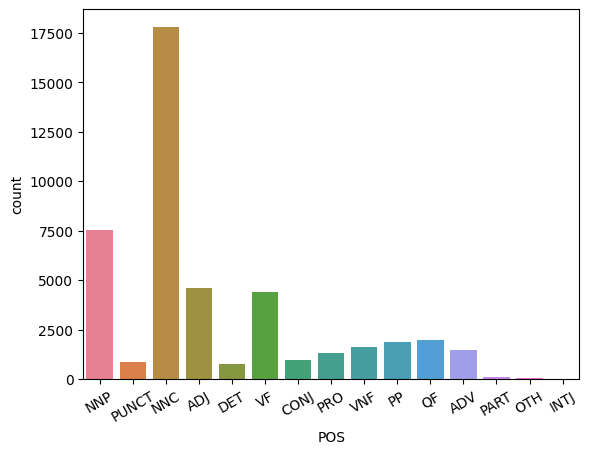

In [42]:
sns.countplot(data=data_cleaned, x='POS', hue = 'POS', dodge=False).legend_
plt.xticks(rotation=30)
plt.show()

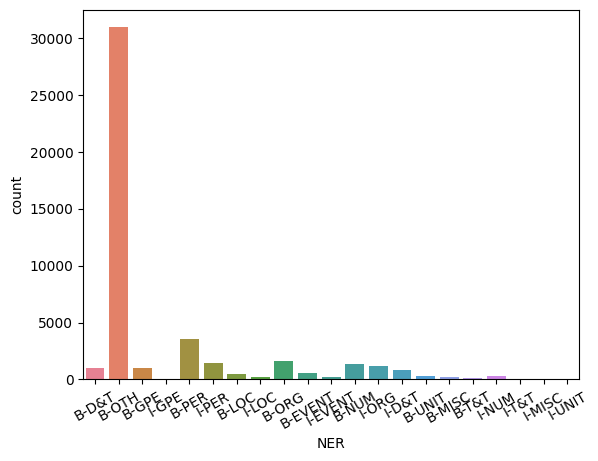

In [44]:
sns.countplot(data=data_cleaned, x='NER', hue = 'NER', dodge=False).legend_
plt.xticks(rotation=30)
plt.show()

### Tokenize and Pad Sequences

In [45]:
# from bnlp import NLTKTokenizer

# bnltk = NLTKTokenizer()

# text = "আমি ভাত খাই। সে বাজারে যায়। তিনি কি সত্যিই ভালো মানুষ?"
# word_tokens = bnltk.word_tokenize(text)
# sentence_tokens = bnltk.sentence_tokenize(text)
# print(word_tokens)
# print(sentence_tokens)

In [46]:
words = list(set(data_cleaned['Token'].values))
# put padding end token at the end
words.append('ENDPAD')
nbr_words = len(words)
nbr_words

14510

In [47]:
poss = list(set(data_cleaned['POS'].values))
nbr_pos = len(poss)
nbr_pos

15

In [48]:
ners = list(set(data_cleaned['NER'].values))
nbr_ners = len(ners)
nbr_ners

21

In [49]:
# # Check lengths of sequences
# print(f"Token sequence length: {sequences.shape[1]}")
# print(f"POS sequence length: {pos_sequences.shape[1]}")
# print(f"NER sequence length: {ner_sequences.shape[1]}")

# # Verify that all sequences have the same length
# assert sequences.shape[1] == pos_sequences.shape[1] == ner_sequences.shape[1], "Sequences have different lengths!"

In [50]:
def combine_word_ner_pos(data):
    """
    Input (Pandas DataFrame): containing the dataset we want to group by sentence
    Output (2D list): a 2D list where wach inner list corresponds to sentence and has tuples like so (word, pos, ner)
    """
    # create the list of tuples (word, pos, tag)
    tuples_fun =  lambda s:[(word, pos, ner) for word, pos, ner in zip(s['Token'].values.tolist(), s['POS'].values.tolist(), s['NER'].values.tolist())]
    # group tuples by sentence to create the second dimension
    combination = data.groupby('Sentence #').apply(tuples_fun).tolist()
    
    return combination

In [51]:
# apply the function on the dataset
combination = combine_word_ner_pos(data_cleaned)
combination[:5]

[[('শনিবার', 'NNP', 'B-D&T'),
  ('(', 'PUNCT', 'B-OTH'),
  ('আগস্ট', 'NNP', 'B-D&T'),
  ('রাতে', 'NNC', 'B-D&T'),
  ('পটুয়াখালী', 'NNP', 'B-GPE'),
  ('সদর', 'NNC', 'I-GPE'),
  ('থানার', 'NNC', 'I-GPE'),
  ('ভারপ্রাপ্ত', 'ADJ', 'B-PER'),
  ('কর্মকর্তা', 'NNC', 'I-PER'),
  ('( ওসি )', 'PUNCT', 'B-OTH'),
  ('মো.', 'NNP', 'B-PER'),
  ('মনিরুজ্জামান', 'NNP', 'I-PER'),
  ('এ', 'DET', 'B-OTH'),
  ('তথ্য', 'NNC', 'B-OTH'),
  ('নিশ্চিত', 'ADJ', 'B-OTH'),
  ('করেছেন', 'VF', 'B-OTH')],
 [('বায়ুদূষণ', 'NNC', 'B-OTH'),
  ('ও', 'CONJ', 'B-OTH'),
  ('স্মার্ট', 'NNC', 'B-OTH'),
  ('ফোন', 'NNC', 'B-OTH'),
  ('ছেলেমেয়ে', 'NNC', 'B-PER'),
  ('উভয়ের', 'PRO', 'B-OTH'),
  ('প্রজনন', 'NNC', 'B-OTH'),
  ('ক্ষমতা', 'NNC', 'B-OTH'),
  ('হ্রাস', 'NNC', 'B-OTH'),
  ('করে', 'VNF', 'B-OTH'),
  ('দিচ্ছে', 'VF', 'B-OTH')],
 [('ছাত্র', 'NNC', 'B-OTH'),
  ('রাজনীতির', 'NNC', 'B-OTH'),
  ('বর্তমান', 'ADJ', 'B-OTH'),
  ('অবস্থার', 'NNC', 'B-OTH'),
  ('শুরু', 'NNC', 'B-OTH'),
  ('হয়েছিলো', 'VF', 'B-OTH'),
  ('স্বৈরশাস

#### Building the vocabulary

In [52]:

words_vocab = {word: i for i, word in enumerate(words)}
ners_vocab = {ner: i for i, ner in enumerate(ners)}
pos_vocab = {pos: i for i, pos in enumerate(poss)}

print(list(words_vocab)[:5])
print(list(pos_vocab))
print(list(ners_vocab))

['সীমান্তবর্তী', 'সিদ্ধহস্ত', 'নাবা', 'চিফ', 'মার্চ']
['OTH', 'VF', 'PP', 'DET', 'PRO', 'VNF', 'ADV', 'NNC', 'NNP', 'QF', 'PART', 'ADJ', 'CONJ', 'PUNCT', 'INTJ']
['B-ORG', 'B-PER', 'B-GPE', 'I-UNIT', 'B-MISC', 'I-T&T', 'B-OTH', 'I-NUM', 'I-PER', 'I-EVENT', 'I-MISC', 'I-GPE', 'I-ORG', 'B-D&T', 'B-UNIT', 'B-NUM', 'I-D&T', 'B-LOC', 'B-EVENT', 'I-LOC', 'B-T&T']


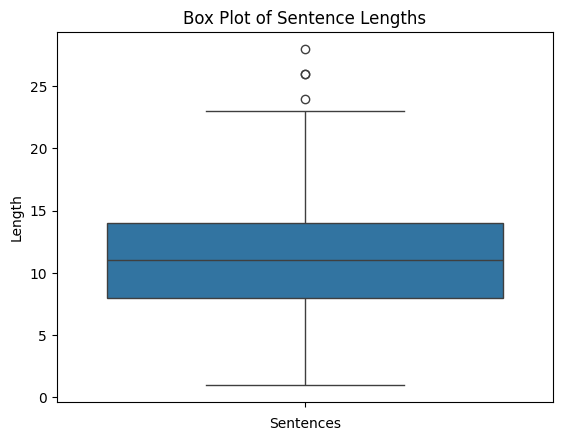

In [53]:
# Calculate the lengths of the sentences
sentence_lengths = [len(c) for c in combination]

# Create the box plot
sns.boxplot(y=sentence_lengths)

# Set plot labels
plt.xlabel('Sentences')
plt.ylabel('Length')
plt.title('Box Plot of Sentence Lengths')

# Show the plot
plt.show()

We will take it as maximum length (25, disregarding the outliers) to take into consideration the longer sentences as well - and pad any shorter ones.

In [54]:
list(words_vocab.items())[nbr_words-1]

('ENDPAD', 14509)

In [55]:
list(pos_vocab.items())[nbr_pos-1]

('INTJ', 14)

In [56]:
pos_vocab

{'OTH': 0,
 'VF': 1,
 'PP': 2,
 'DET': 3,
 'PRO': 4,
 'VNF': 5,
 'ADV': 6,
 'NNC': 7,
 'NNP': 8,
 'QF': 9,
 'PART': 10,
 'ADJ': 11,
 'CONJ': 12,
 'PUNCT': 13,
 'INTJ': 14}

In [57]:
from keras_preprocessing.sequence import pad_sequences
# define maximum sentence length
max_len = 25

# creating the features set
# getting nbr representation for each word
x = [[words_vocab[tuple[0]] for tuple in c] for c in combination]
# padding the sentences so they would all be 25 words (padding value: 'ENDPAD')
x = pad_sequences(maxlen=max_len, sequences = x, padding='post', value = nbr_words-1)

# creating the target set
# getting nbr representation for each pos and ner
y_pos = [[pos_vocab[tuple[1]] for tuple in c] for c in combination]
y_pos = pad_sequences(maxlen=max_len, sequences=y_pos, padding='post', value = nbr_pos-1)

y_ner = [[ners_vocab[tuple[2]] for tuple in c] for c in combination]
y_ner = pad_sequences(maxlen=max_len, sequences=y_ner, padding='post', value = nbr_ners-1)

In [58]:
# take a look at the x and y sets
print('feature set: ',x[:2])
print('pos labels: ', y_pos[:2])
print('ner labels: ', y_ner[:2])

feature set:  [[11980  6177  9578  5892  9701  6409  9798 14164  3949  5946 10594  3014
  12997  2577  5129  8540 14509 14509 14509 14509 14509 14509 14509 14509
  14509]
 [ 7426  3302  7016 14106 10740  5198  1898  2548   919  2215  6422 14509
  14509 14509 14509 14509 14509 14509 14509 14509 14509 14509 14509 14509
  14509]]
pos labels:  [[ 8 13  8  7  8  7  7 11  7 13  8  8  3  7 11  1 14 14 14 14 14 14 14 14
  14]
 [ 7 12  7  7  7  4  7  7  7  5  1 14 14 14 14 14 14 14 14 14 14 14 14 14
  14]]
ner labels:  [[13  6 13 13  2 11 11  1  8  6  1  8  6  6  6  6 20 20 20 20 20 20 20 20
  20]
 [ 6  6  6  6  1  6  6  6  6  6  6 20 20 20 20 20 20 20 20 20 20 20 20 20
  20]]


### Handling imbalance

Resample on a Per-Sentence Basis:

1. Flatten the sequences to get a single array of labels.
2. Apply resampling techniques on this flattened array.
3. Map the resampled labels back to the original sequence format.

In [64]:
import random
import numpy as np
import tensorflow as tf
# Set the seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [65]:
# from imblearn.over_sampling import SMOTE

# # Flatten the label sequences for POS and NER
# flattened_y_pos = [label for seq in y_pos for label in seq]
# flattened_y_ner = [label for seq in y_ner for label in seq]

# # Reshape the input features to match the flattened labels
# flattened_x = [item for sublist in x for item in sublist]

In [66]:
# # Apply SMOTE
# smote = SMOTE(random_state=seed)
# x_resampled, y_resampled_pos = smote.fit_resample(np.array(flattened_x).reshape(-1, 1), flattened_y_pos)
# _, y_resampled_ner = smote.fit_resample(np.array(flattened_x).reshape(-1, 1), flattened_y_ner)

In [67]:
# # Reshape back to original sequence format
# def reshape_sequences(data, seq_lengths, num_classes):
#     reshaped_data = []
#     index = 0
#     for length in seq_lengths:
#         reshaped_data.append(data[index:index+length])
#         index += length
#     return reshaped_data

# seq_lengths = [len(seq) for seq in x]
# x_resampled = reshape_sequences(x_resampled.flatten(), seq_lengths, num_classes=nbr_words)
# y_resampled_pos = reshape_sequences(y_resampled_pos, seq_lengths, num_classes=nbr_pos)
# y_resampled_ner = reshape_sequences(y_resampled_ner, seq_lengths, num_classes=nbr_ners)

### Train-Test (Validation Split will be done before the model definition)

In [68]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y_pos, test_y_pos, train_y_ner, test_y_ner = train_test_split(
    x, y_pos, y_ner, test_size=0.2, random_state=seed)

In [69]:
# from collections import Counter

# # Flatten the sequences
# flat_y_pos = [label for seq in y_pos for label in seq]
# flat_y_ner = [label for seq in y_ner for label in seq]

# # Count occurrences
# pos_counts = Counter(flat_y_pos)
# ner_counts = Counter(flat_y_ner)

# # Print class frequencies
# print("POS Tag Frequencies:")
# for tag, count in pos_counts.items():
#     print(f"{tag}: {count}")

# print("\nNER Tag Frequencies:")
# for tag, count in ner_counts.items():
#     print(f"{tag}: {count}")

In [70]:
# from collections import Counter

# # Check distribution of NER tags in each set
# def check_distribution(y):
#     return Counter(np.concatenate(y))

# print("Train NER distribution:", check_distribution(train_y_ner))
# print("Test NER distribution:", check_distribution(test_y_ner))


# # Check distributions after split
# print("Test NER distribution:", check_distribution(test_y_ner))

In [71]:
# Ensure that the shapes match for all arrays
print(f"Train X shape: {train_x.shape}")
print(f"Test X shape: {test_x.shape}")
print(f"Train Y POS shape: {train_y_pos.shape}")
print(f"Test Y POS shape: {test_y_pos.shape}")
print(f"Train Y NER shape: {train_y_ner.shape}")
print(f"Test Y NER shape: {test_y_ner.shape}")

Train X shape: (3246, 25)
Test X shape: (812, 25)
Train Y POS shape: (3246, 25)
Test Y POS shape: (812, 25)
Train Y NER shape: (3246, 25)
Test Y NER shape: (812, 25)


In [72]:
import numpy as np
import pickle
import os

os.makedirs('processed_data', exist_ok=True)

# Save the arrays
np.save('./processed_data/train_x.npy', train_x)
np.save('./processed_data/test_x.npy', test_x)
np.save('./processed_data/train_y_pos.npy', train_y_pos)
np.save('./processed_data/test_y_pos.npy', test_y_pos)
np.save('./processed_data/train_y_ner.npy', train_y_ner)
np.save('./processed_data/test_y_ner.npy', test_y_ner)

# Save the vocab dictionaries
with open('./processed_data/words_vocab.pkl', 'wb') as f:
    pickle.dump(words_vocab, f)

with open('./processed_data/pos_vocab.pkl', 'wb') as f:
    pickle.dump(pos_vocab, f)

with open('./processed_data/ners_vocab.pkl', 'wb') as f:
    pickle.dump(ners_vocab, f)

# Save the words, poss, and ners lists
with open('processed_data/words.pkl', 'wb') as f:
    pickle.dump(words, f)

with open('processed_data/poss.pkl', 'wb') as f:
    pickle.dump(poss, f)

with open('processed_data/ners.pkl', 'wb') as f:
    pickle.dump(ners, f)